# Training models on campaigns in the same area 
## Operator 1

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM # type: ignore
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

In [40]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

plt.rcParams.update({'font.size': 18})

### Processing functions

In [41]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

## LSTM functions

In [42]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': # set new current campaign if there is no campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)


'''
    Returns the mean absolute error on each datapoint
'''
def single_point_mae(y_pred, y_true):
    pred_series, true_series = [], []

    for i in range(len(y_pred)):
        for k in range(len(y_pred[i])):
            pred_series.append(y_pred[i][k])
            true_series.append(y_true[i][k])

    pred_series, true_series = np.array(pred_series), np.array(true_series)

    return np.mean(np.abs(pred_series - true_series)), np.abs(pred_series - true_series)


def long_short_term_memory(train, test, target_feature:str, features:list, campaigns:list, test_campaigns:list, n_steps_in=5, n_steps_out=1, n_first_units=5, n_second_units=10):

    features.remove('campaign')

    idx_target = features.index(target_feature)

    scaler = MinMaxScaler()
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])

    X, y = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
    X_test, y_test = series_split_sequences(test, test[target_feature], n_steps_in, n_steps_out)

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    # optimizer = RMSprop(learning_rate=0.001, rho=0.9) # , epsilon=None) 

    model = Sequential()
    model.add(LSTM(units=n_first_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=True, return_state=False
                   ))
    # model.add(Dropout(0.2))
    model.add(LSTM(units=n_second_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    # model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    
    history = model.fit(X_train, y_train,
              epochs=100,
              validation_data=(X_val, y_val),
              shuffle=True, verbose=0)   

    scaler_pred = MinMaxScaler()
    scaler_pred.min_, scaler_pred.scale_ = scaler.min_[idx_target], scaler.scale_[idx_target]

    # prepare test data for plots
    if len(test_campaigns) == 1:
        y_pred = model.predict(X_test, verbose=0) 

        y_pred = scaler_pred.inverse_transform(y_pred)
        y_true = scaler_pred.inverse_transform(y_test)
        test[features] = scaler.inverse_transform(test[features])

        y_true_plot = test[target_feature].values
        y_pred_plot = np.empty_like(test)
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(test), :] = y_pred

        train_pred = model.predict(X, verbose=0)

        train_pred = scaler_pred.inverse_transform(train_pred)
        train[features] = scaler.inverse_transform(train[features])
        _, test_y_seq = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
        
        y_train_plot = train[target_feature].values
        train_pred_plot = np.empty_like(train)
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(train), :] = train_pred

    else:
        test_test = test[test['campaign'] == test_campaigns[0]]
        test_seq, test_test_seq = series_split_sequences(test_test, test_test[target_feature], n_steps_in, n_steps_out)
        y_pred = model.predict(test_seq, verbose=0)

        y_pred = scaler_pred.inverse_transform(y_pred)
        y_true = scaler_pred.inverse_transform(test_test_seq)
        test_test[features] = scaler.inverse_transform(test_test[features])

        y_true_plot = test_test[target_feature].values
        y_pred_plot = np.empty_like(test_test)
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(test_test), :] = y_pred

        test_train = train[train['campaign'] == campaigns[0]]
        test_train_seq, test_y_seq = series_split_sequences(test_train, test_train[target_feature], n_steps_in, n_steps_out)
        train_pred = model.predict(test_train_seq, verbose=0)

        train_pred = scaler_pred.inverse_transform(train_pred)
        test_train[features] = scaler.inverse_transform(test_train[features])
        test_y_seq = scaler_pred.inverse_transform(test_y_seq)

        y_train_plot = test_train[target_feature].values
        train_pred_plot = np.empty_like(test_train)
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(test_train), :] = train_pred

    mae = single_point_mae(y_pred, y_true)
    train_mae = single_point_mae(train_pred, test_y_seq)

    results = {'y_pred': y_pred_plot,
               'y_true': y_true_plot,
               'train_pred': train_pred_plot,
               'train_true': y_train_plot,
               'loss' : history.history['loss'],
               'loss_final' : round(history.history['loss'][-1], 5),
               'val_loss' : history.history['val_loss'],
               'val_loss_final' : round(history.history['val_loss'][-1], 5),
               'mae': round(mae[0], 2),
               'list_mae': mae[1],
               'train_mae': round(train_mae[0], 2),
               'train_list_mae': train_mae[1]
               }

    return results

### Random Forest functions

In [43]:
def rf(X_train, X_test, mode_train, mode_test, campaigns, test_campaigns, features, n_estimators=100, max_depth=None, min_samples_leaf=1):
    permutation = np.random.permutation(X_train.index)
    X_train_randomized = X_train.reindex(permutation).reset_index(drop=True)
    mode_train_randomized = mode_train.reindex(permutation).reset_index(drop=True)

    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    smote = SMOTE()
    # rus = RandomUnderSampler() 
    X_train_balanced, mode_train_balanced = smote.fit_resample(X_train_randomized[features], mode_train_randomized['Mode'])
    # X_train_balanced, mode_train_balanced = rus.fit_resample(X_train_balanced, mode_train_balanced)

    rf.fit(X_train_balanced, mode_train_balanced)

    if len(test_campaigns) == 1:
        y_pred = rf.predict(X_test[features])

        accuracy = accuracy_score(mode_test['Mode'], y_pred)
        precision = precision_score(mode_test['Mode'], y_pred)
        recall = recall_score(mode_test['Mode'], y_pred)

        y_true = mode_test['Mode']

        

        train_pred = rf.predict(X_train[features])

        train_accuracy = accuracy_score(mode_train['Mode'], train_pred)
        train_precision = precision_score(mode_train['Mode'], train_pred)
        train_recall = recall_score(mode_train['Mode'], train_pred)

        train_true = mode_train['Mode']
    else:
        X_test_test = X_test[X_test['campaign'] == test_campaigns[0]]
        X_test_mode = mode_test[mode_test['campaign'] == test_campaigns[0]]
        
        y_pred = rf.predict(X_test_test[features])

        y_pred_total = rf.predict(X_test[features])
        accuracy = accuracy_score(mode_test['Mode'], y_pred_total)
        precision = precision_score(mode_test['Mode'], y_pred_total)
        recall = recall_score(mode_test['Mode'], y_pred_total)

        y_true = X_test_mode['Mode']

        X_train_test = X_train[X_train['campaign'] == campaigns[0]]
        X_train_mode = mode_train[mode_train['campaign'] == campaigns[0]]

        train_pred = rf.predict(X_train_test[features])

        train_pred_total = rf.predict(X_train[features])
        train_accuracy = accuracy_score(mode_train['Mode'], train_pred_total)
        train_precision = precision_score(mode_train['Mode'], train_pred_total)
        train_recall = recall_score(mode_train['Mode'], train_pred_total)

        train_true = X_train_mode['Mode']

    results = {'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'y_true' : y_true,
               'y_pred' : y_pred,
               'train_true': train_true,
               'train_pred': train_pred,
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'model': rf}
    return results

def plot_mode(pred, true, operator:str, comb:str, campaigns:list, test_campaigns:list, test_train='Test', colors=mode_colors):
    fig = plt.figure(figsize=(16, 6))
    plt.grid(zorder=0)
    plt.plot(pred, color=colors[1], label='Predicted', zorder=2)
    plt.plot(true + 2, color=colors[3], label='True', zorder=3)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('HO')
    plt.ylim((-0.2, 3.4))
    plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
    plt.title(f'{test_train} data -- {operator}\nParameters: {comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
    plt.legend(ncols=3, loc='best')
    plt.show()

    return fig

In [44]:
# Parameters
tf.random.set_seed(4567)
dataset = 'datasets/Op1_merged.csv'
operator = 'Operator 1'

# LSTM
n_steps_in = 2
n_steps_out = 1

n_first_units = 5
n_second_units = 10

# Random Forest
n_estimators = 100
max_depth = 10

### Overlapping campaigns from dataset

* Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi, Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode, Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode, Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode, Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi

* Ping_UNIDATA_4G5G_TIM_Walking_Termini_to_DIET, Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Termini, Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel, Interactivity_gaming_4G5G_TIM_Walking_Termini_to_DIET_Test_2_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel

* Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia, Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia_Part_2, Interactivity_gaming_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia, Capacity_Ookla_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode

* Ping_UNIDATA_4G5G_TIM_Driving_Luca, Interactivity_gaming_4G5G_TIM_Driving_Luca, Capacity_Ookla_4G5G_Tim_Driving_Luca

In [47]:
overlap_1 = ['Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode',
             'Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
             'Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
             'Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode',
             'Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode']

overlap_2 = ['Ping_UNIDATA_4G5G_TIM_Walking_Termini_to_DIET', 
             'Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Termini', 
             'Ping_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel', 
             'Interactivity_gaming_4G5G_TIM_Walking_Termini_to_DIET_Test_2_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_DIET_to_Labicana_Hotel']

overlap_3 = ['Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia', 
             'Ping_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia_Part_2', 
             'Interactivity_gaming_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_TIM_Walking_Tuscolana_Stat_Appia', 
             'Capacity_Ookla_4G5G_TIM_Driving_Tuscolana_Stat_Appia_No_Flight_Mode']

overlap_4 = ['Ping_UNIDATA_4G5G_TIM_Driving_Luca', 
             'Interactivity_gaming_4G5G_TIM_Driving_Luca', 
             'Capacity_Ookla_4G5G_Tim_Driving_Luca']

In [48]:
train = read_dataset(dataset, campaigns=[overlap_1[1]])
test = read_dataset(dataset, campaigns=[overlap_1[0]])

## LSTM

In [49]:
target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [#['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], ['RSRP', 'SINR', 'RSRQ'],
                     #['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

lstm_results = {}

In [50]:
for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)

In [51]:
df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

,Combination,loss_final,val_loss_final,mae,train_mae
0,"RSRP, SINR -> RSRP",0.00251,0.00364,0.82,1.23
1,"RSRP, RSRQ -> RSRP",0.00168,0.00155,0.51,0.67
2,"RSRP, SINR, RSRQ -> RSRP",0.00174,0.00177,0.69,0.83
3,"RSRP, SSS_RSRP -> RSRP",0.00184,0.00190,0.71,0.95
4,All -> RSRP,0.00211,0.00232,0.88,1.08
5,"RSRP, SINR -> SINR",0.00155,0.00225,0.59,0.90
6,"SINR, RSRQ -> SINR",0.00145,0.00206,0.41,0.71
7,"RSRP, SINR, RSRQ -> SINR",0.00153,0.00297,0.56,0.92
8,"SINR, SSS_SINR -> SINR",0.00172,0.00640,0.53,1.09
9,All -> SINR,0.00169,0.00199,0.56,0.88


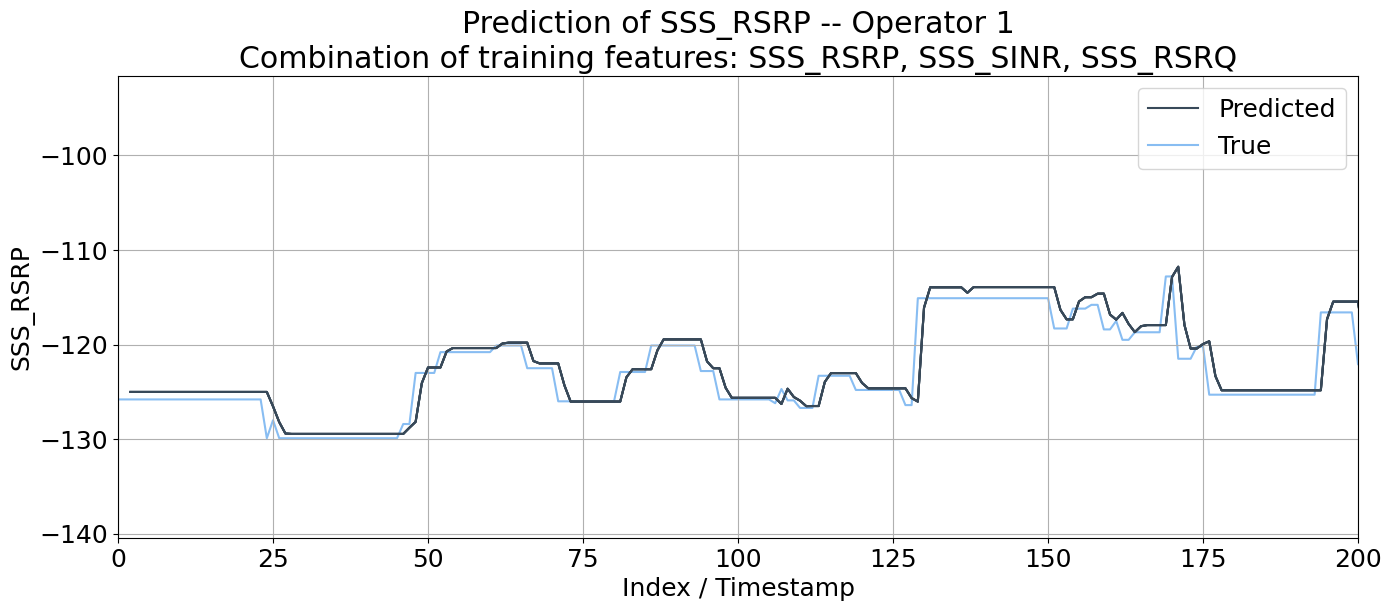

In [52]:
selected_sss_rsrp_comb = 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP'
sss_rsrp_comb = lstm_results[selected_sss_rsrp_comb]
sss_rsrp_pred = sss_rsrp_comb['y_pred']
sss_rsrp_true = sss_rsrp_comb['y_true']
sss_rsrp_train_pred = sss_rsrp_comb['train_pred']
sss_rsrp_train_true = sss_rsrp_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(sss_rsrp_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(sss_rsrp_true, label='True', color=rsrp_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.ylabel('SSS_RSRP')
plt.xlim((0, 200))
plt.title(f'Prediction of SSS_RSRP -- {operator}\nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

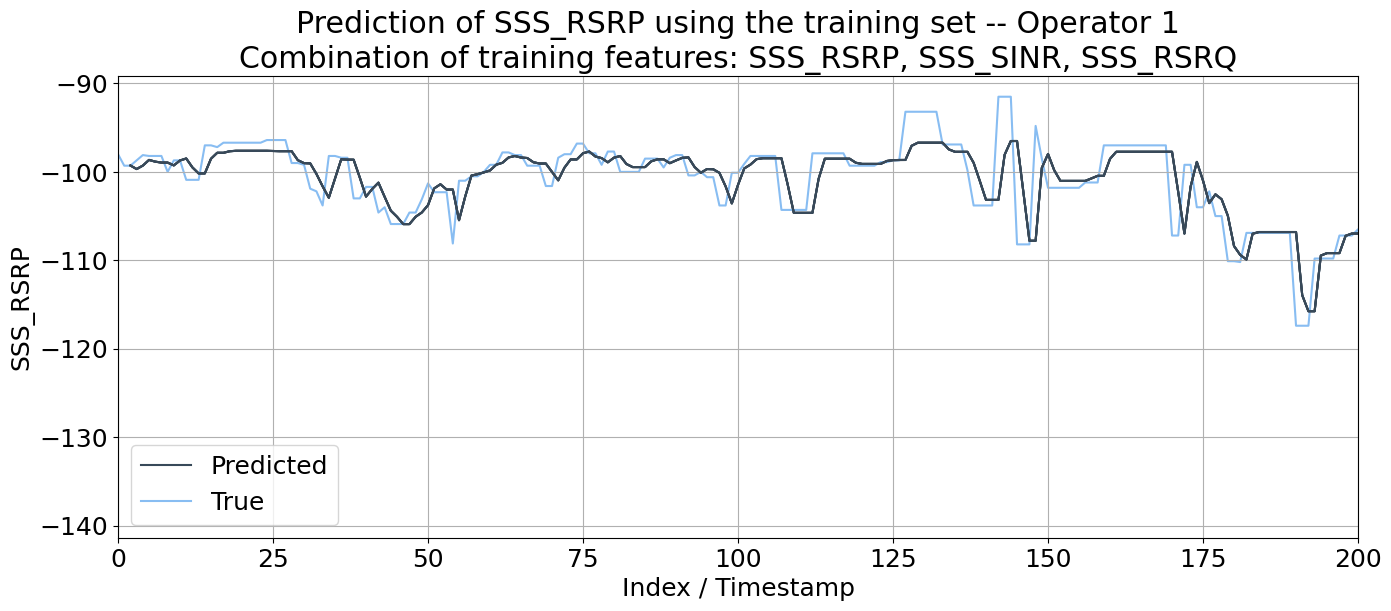

In [53]:
f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(sss_rsrp_train_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(sss_rsrp_train_true, label='True', color=rsrp_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.xlim((0, 200))
plt.ylabel('SSS_RSRP')
plt.title(f'Prediction of SSS_RSRP using the training set -- {operator}\nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

## Random Forest

In [54]:
est_try = [5, 10, 20, 50, 80, 100, 120, 150, 200, 250, 300]
min_leaf_size = [1, 2, 5, 7, 9, 12, 15]

### Overlap 1

#### Train 1 campaign -- Test 1 campaign

In [55]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]
campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.554,0.540,0.082,1.000,1.000,0.997
1,"n_est: 5, min_leaf: 2",0.573,0.627,0.135,1.000,1.000,0.997
2,"n_est: 5, min_leaf: 5",0.581,0.634,0.171,0.995,0.970,1.000
3,"n_est: 5, min_leaf: 7",0.551,0.513,0.122,0.992,0.960,0.995
4,"n_est: 5, min_leaf: 9",0.557,0.542,0.121,0.991,0.953,0.997
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.559,0.571,0.099,0.998,0.990,1.000
73,"n_est: 300, min_leaf: 7",0.563,0.584,0.117,0.995,0.977,0.992
74,"n_est: 300, min_leaf: 9",0.562,0.577,0.118,0.995,0.977,0.992
75,"n_est: 300, min_leaf: 12",0.555,0.535,0.113,0.993,0.967,0.992


In [56]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.561
Mean precision: 0.572
Mean recall: 0.112


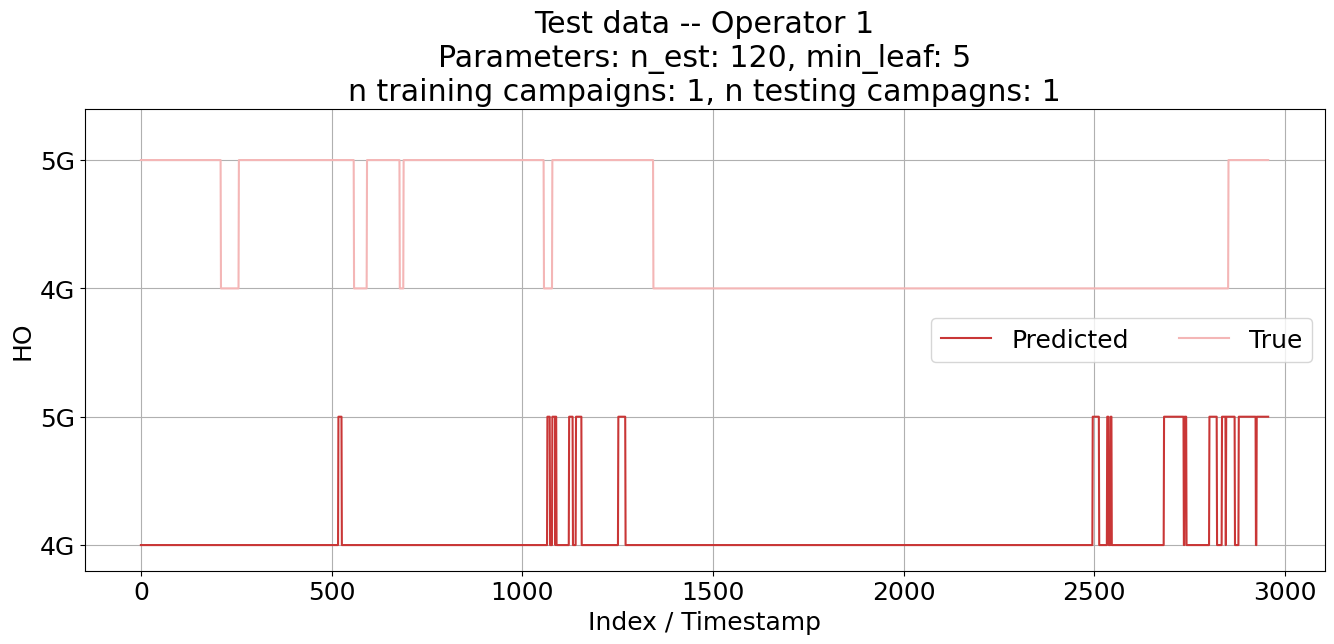

In [57]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true'].values

fig = plot_mode(pred=rf_pred, true=rf_true, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/rf/op1_1_campaign_train.pdf')

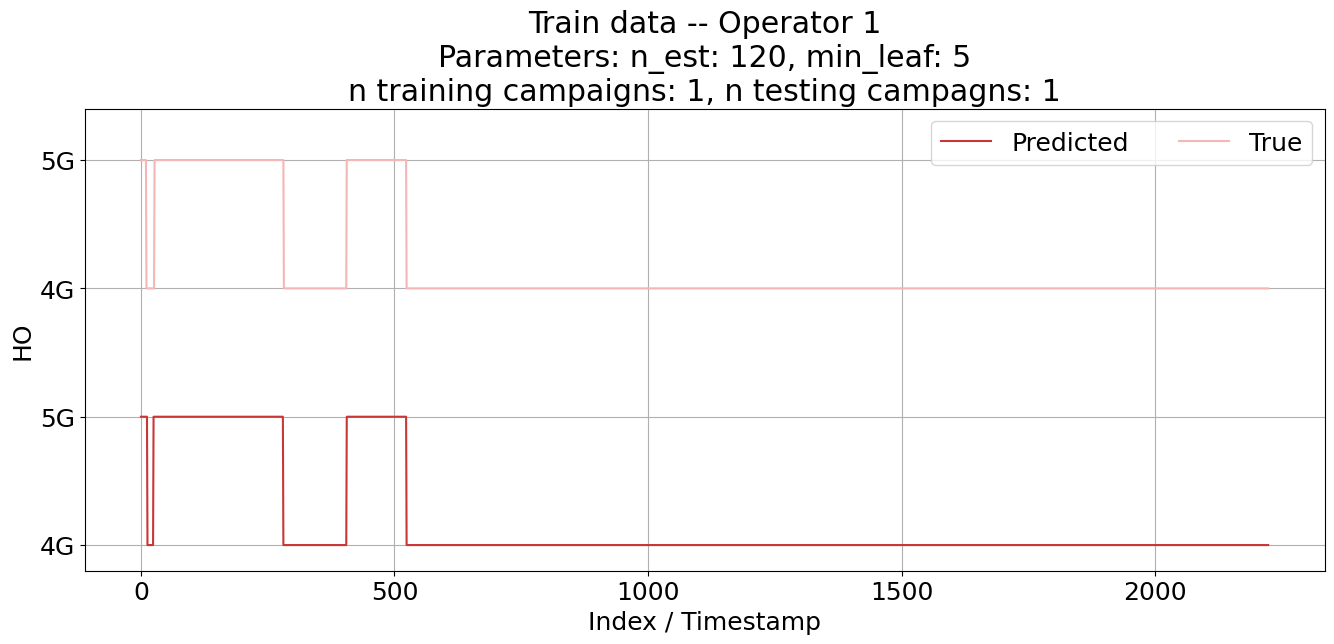

In [58]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true'].values

fig = plot_mode(pred=rf_pred_train, true=rf_true_train, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns, test_train='Train')
fig.savefig(r'../latex/plots/rf/op1_1_campaign_train_train.pdf')

##### Include location

In [59]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.540,0.449,0.079,1.000,1.000,0.997
1,"n_est: 5, min_leaf: 2",0.520,0.351,0.074,1.000,1.000,0.997
2,"n_est: 5, min_leaf: 5",0.527,0.385,0.079,0.996,0.977,0.997
3,"n_est: 5, min_leaf: 7",0.524,0.374,0.079,0.997,0.985,1.000
4,"n_est: 5, min_leaf: 9",0.541,0.453,0.079,0.995,0.972,0.997
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.527,0.385,0.079,0.998,0.990,1.000
73,"n_est: 300, min_leaf: 7",0.527,0.385,0.079,0.996,0.977,1.000
74,"n_est: 300, min_leaf: 9",0.527,0.385,0.079,0.993,0.962,1.000
75,"n_est: 300, min_leaf: 12",0.527,0.385,0.079,0.992,0.958,1.000


In [60]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.528
Mean precision: 0.390
Mean recall: 0.079


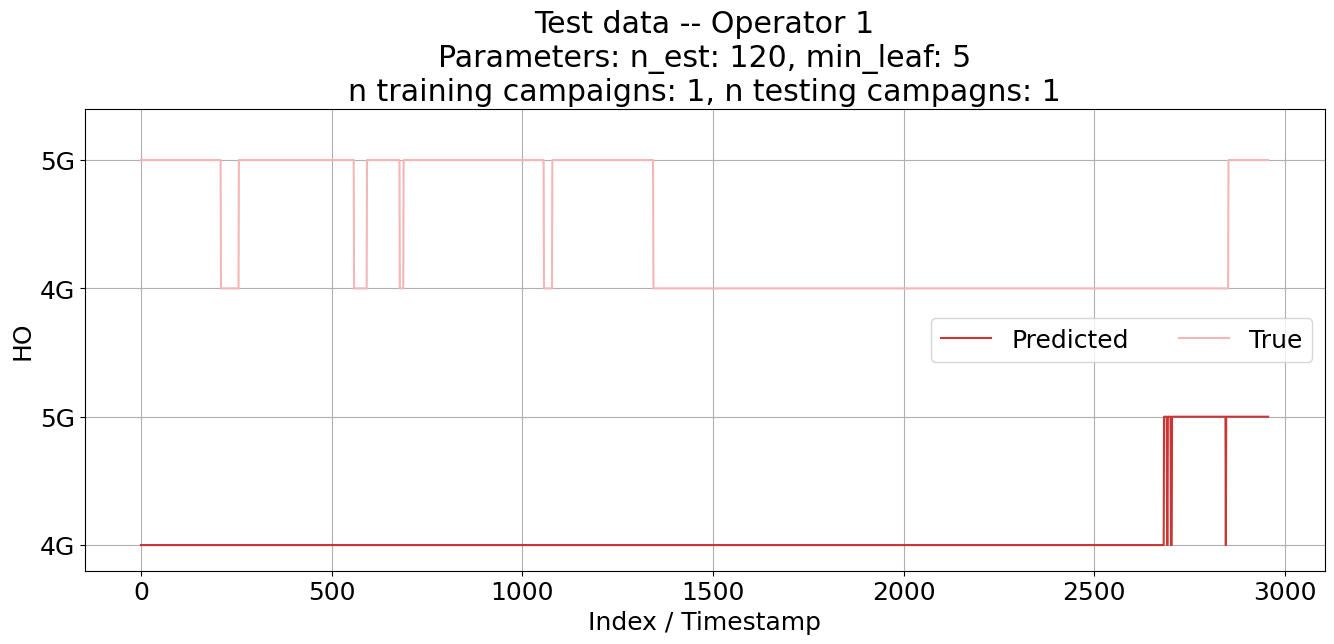

In [61]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true'].values

fig = plot_mode(pred=rf_pred, true=rf_true, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/rf_loc/op1_1_campaign_train_lat_long.pdf')

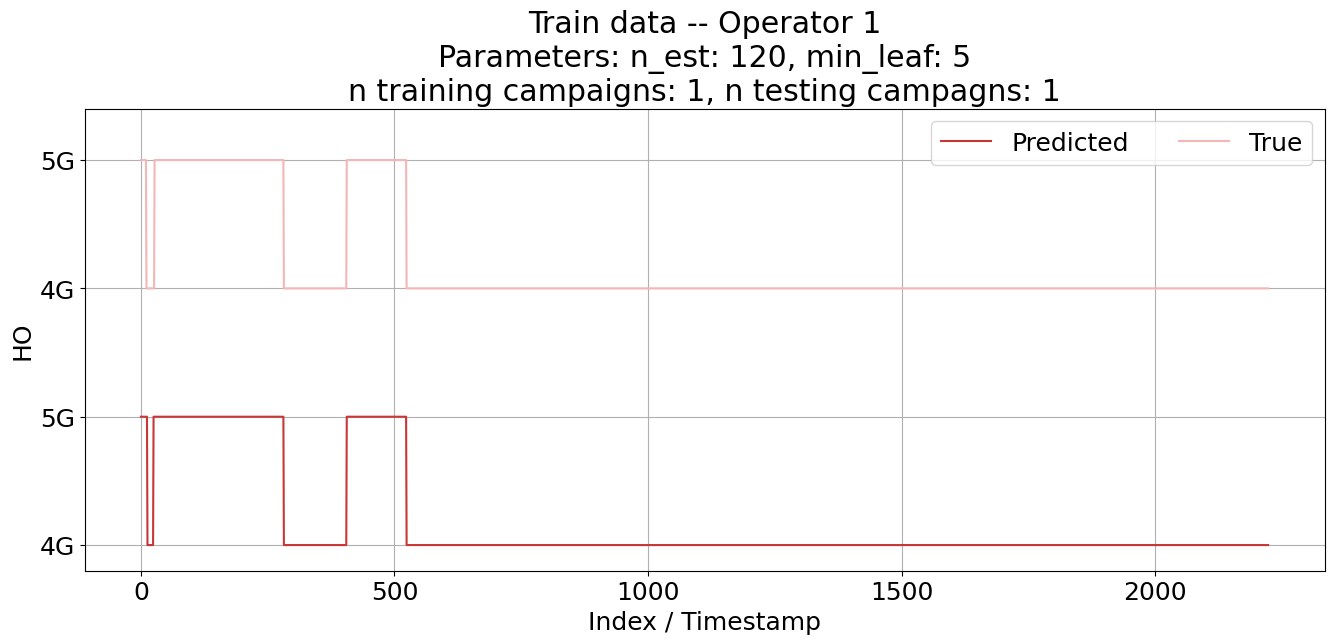

In [62]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true'].values

fig = plot_mode(pred=rf_pred_train, true=rf_true_train, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns, test_train='Train')
fig.savefig(r'../latex/plots/rf_loc/op1_1_campaign_train_lat_long.pdf')

#### Train 2 campaigns -- Test 1 campaign

In [63]:
train = read_dataset(dataset, campaigns=overlap_1[1:3])
test = read_dataset(dataset, campaigns=[overlap_1[0]])
campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [64]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.629,0.637,0.415,0.997,0.993,0.998
1,"n_est: 5, min_leaf: 2",0.624,0.657,0.351,0.996,0.993,0.995
2,"n_est: 5, min_leaf: 5",0.622,0.669,0.322,0.993,0.983,0.993
3,"n_est: 5, min_leaf: 7",0.620,0.648,0.348,0.987,0.974,0.986
4,"n_est: 5, min_leaf: 9",0.629,0.677,0.343,0.985,0.964,0.988
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.645,0.706,0.367,0.995,0.990,0.993
73,"n_est: 300, min_leaf: 7",0.632,0.663,0.376,0.990,0.976,0.993
74,"n_est: 300, min_leaf: 9",0.634,0.666,0.383,0.989,0.974,0.991
75,"n_est: 300, min_leaf: 12",0.630,0.656,0.383,0.984,0.963,0.987


In [65]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.636
Mean precision: 0.680
Mean recall: 0.370


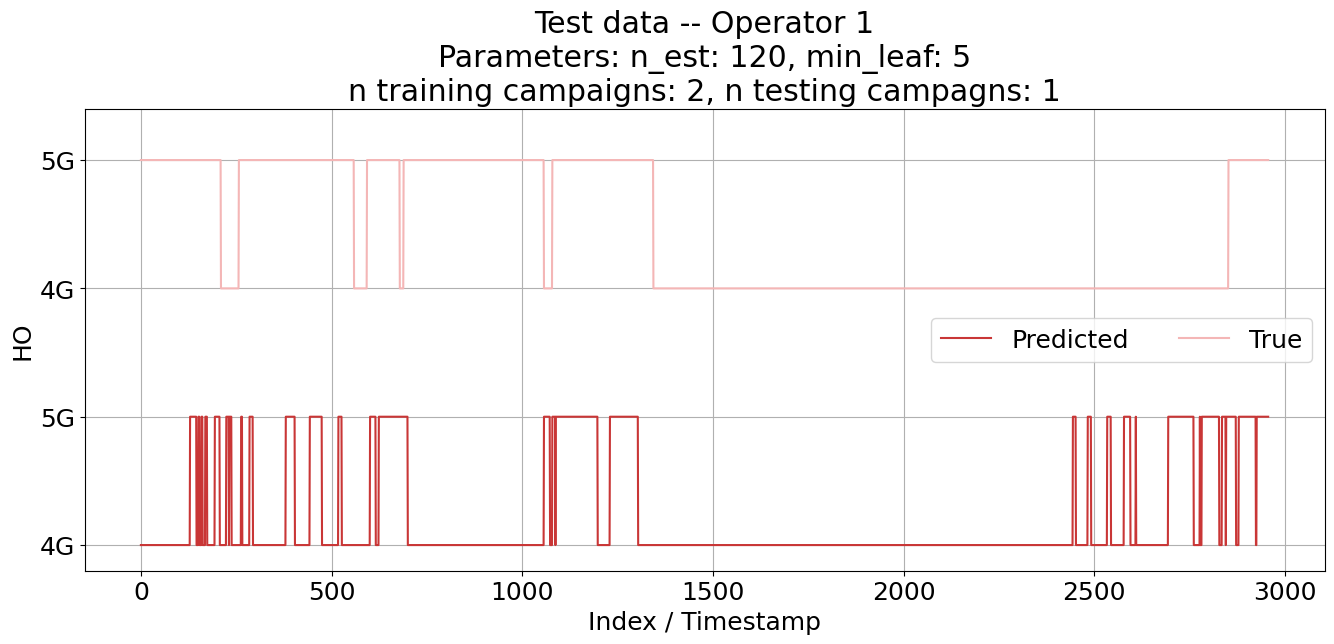

In [66]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true'].values

fig = plot_mode(pred=rf_pred, true=rf_true, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/rf/op1_2_campaign_train.pdf')

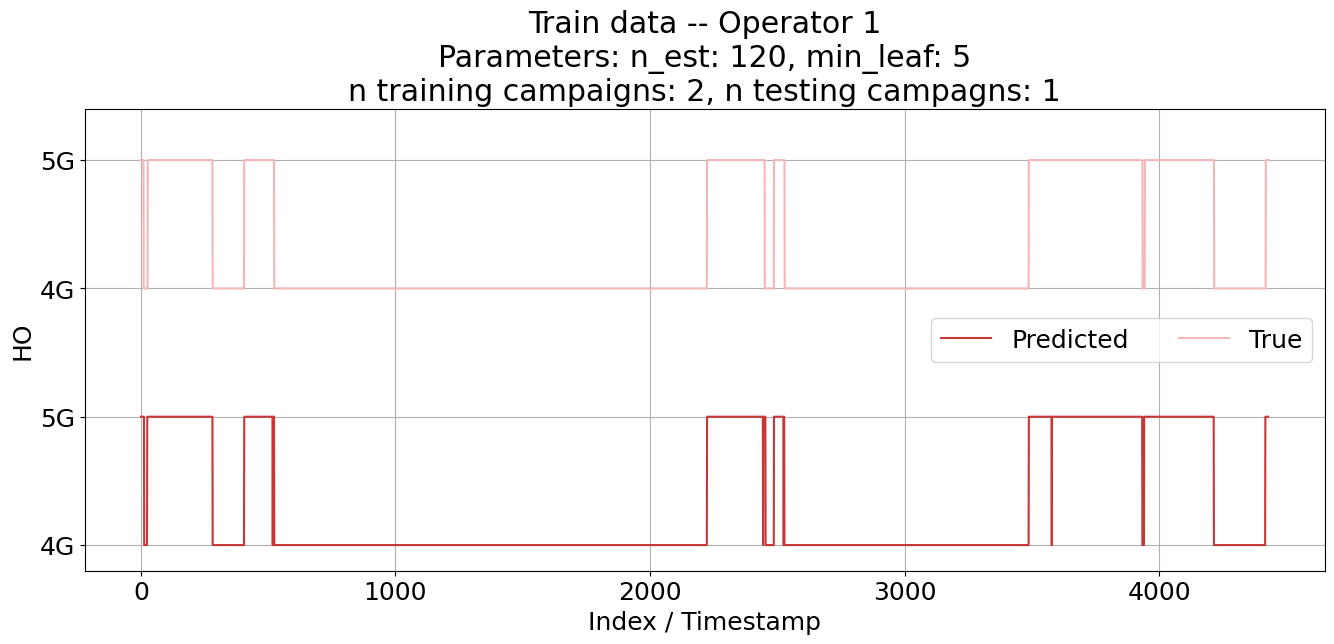

In [67]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true'].values

plot_mode(pred=rf_pred_train, true=rf_true_train, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns, test_train='Train')
fig.savefig(r'../latex/plots/rf/op1_2_campaign_train_train.pdf')

#### Include location

In [68]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.697,0.749,0.496,0.999,0.999,0.999
1,"n_est: 5, min_leaf: 2",0.661,0.694,0.446,0.998,0.996,0.998
2,"n_est: 5, min_leaf: 5",0.679,0.685,0.537,0.994,0.984,0.998
3,"n_est: 5, min_leaf: 7",0.660,0.707,0.423,0.992,0.981,0.995
4,"n_est: 5, min_leaf: 9",0.734,0.752,0.612,0.989,0.974,0.992
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.704,0.753,0.513,0.996,0.989,0.998
73,"n_est: 300, min_leaf: 7",0.695,0.750,0.489,0.995,0.988,0.998
74,"n_est: 300, min_leaf: 9",0.703,0.756,0.507,0.992,0.978,0.998
75,"n_est: 300, min_leaf: 12",0.703,0.752,0.510,0.991,0.977,0.996


In [69]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.697
Mean precision: 0.745
Mean recall: 0.499


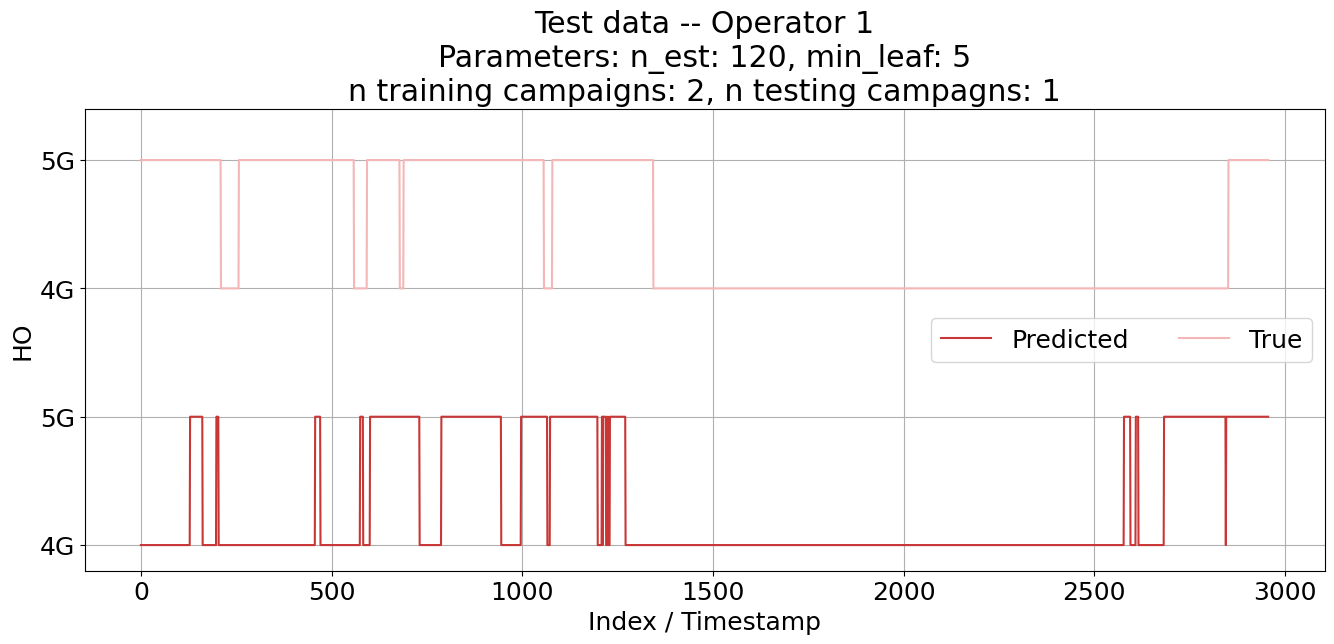

In [70]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true'].values

fig = plot_mode(pred=rf_pred, true=rf_true, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/rf_loc/op1_2_campaign_train_lat_long.pdf')

### Train 3 campaigns -- Test 1 campaign

In [71]:
train = read_dataset(dataset, campaigns=overlap_1[1:4])
test = read_dataset(dataset, campaigns=[overlap_1[0]])
campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [72]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.596,0.609,0.297,0.998,0.995,0.996
1,"n_est: 5, min_leaf: 2",0.604,0.646,0.274,0.996,0.988,0.996
2,"n_est: 5, min_leaf: 5",0.612,0.643,0.316,0.993,0.980,0.991
3,"n_est: 5, min_leaf: 7",0.617,0.687,0.278,0.989,0.970,0.989
4,"n_est: 5, min_leaf: 9",0.639,0.715,0.336,0.988,0.968,0.986
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.641,0.724,0.332,0.995,0.987,0.993
73,"n_est: 300, min_leaf: 7",0.636,0.712,0.328,0.994,0.982,0.994
74,"n_est: 300, min_leaf: 9",0.639,0.721,0.330,0.990,0.971,0.990
75,"n_est: 300, min_leaf: 12",0.642,0.722,0.336,0.986,0.958,0.986


In [73]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.634
Mean precision: 0.707
Mean recall: 0.323


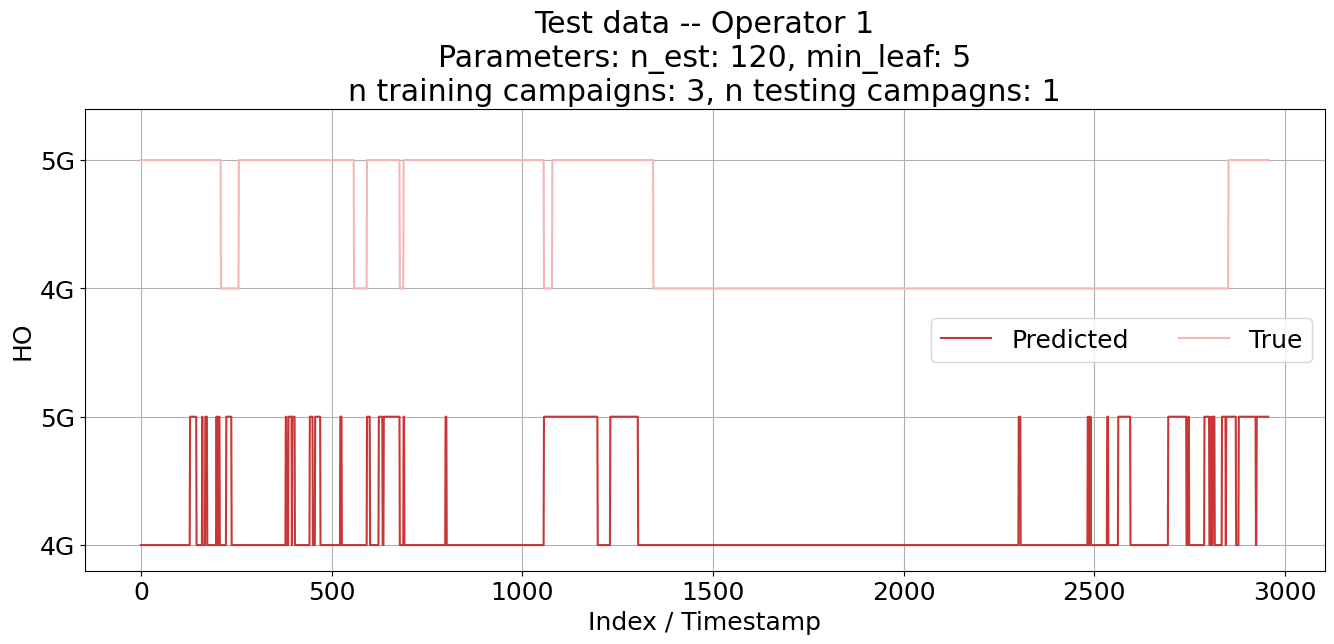

In [74]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true'].values

fig = plot_mode(pred=rf_pred, true=rf_true, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/rf/op1_3_campaign_train.pdf')

#### Include location

In [75]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.624,0.692,0.303,0.999,0.997,0.998
1,"n_est: 5, min_leaf: 2",0.782,0.940,0.553,0.998,0.996,0.997
2,"n_est: 5, min_leaf: 5",0.712,0.913,0.400,0.995,0.986,0.996
3,"n_est: 5, min_leaf: 7",0.634,0.848,0.231,0.993,0.977,0.994
4,"n_est: 5, min_leaf: 9",0.698,0.911,0.367,0.990,0.974,0.988
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.700,0.923,0.368,0.996,0.987,0.998
73,"n_est: 300, min_leaf: 7",0.722,0.925,0.418,0.996,0.986,0.997
74,"n_est: 300, min_leaf: 9",0.731,0.918,0.445,0.995,0.984,0.996
75,"n_est: 300, min_leaf: 12",0.743,0.932,0.464,0.992,0.973,0.997


In [76]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.712
Mean precision: 0.923
Mean recall: 0.394


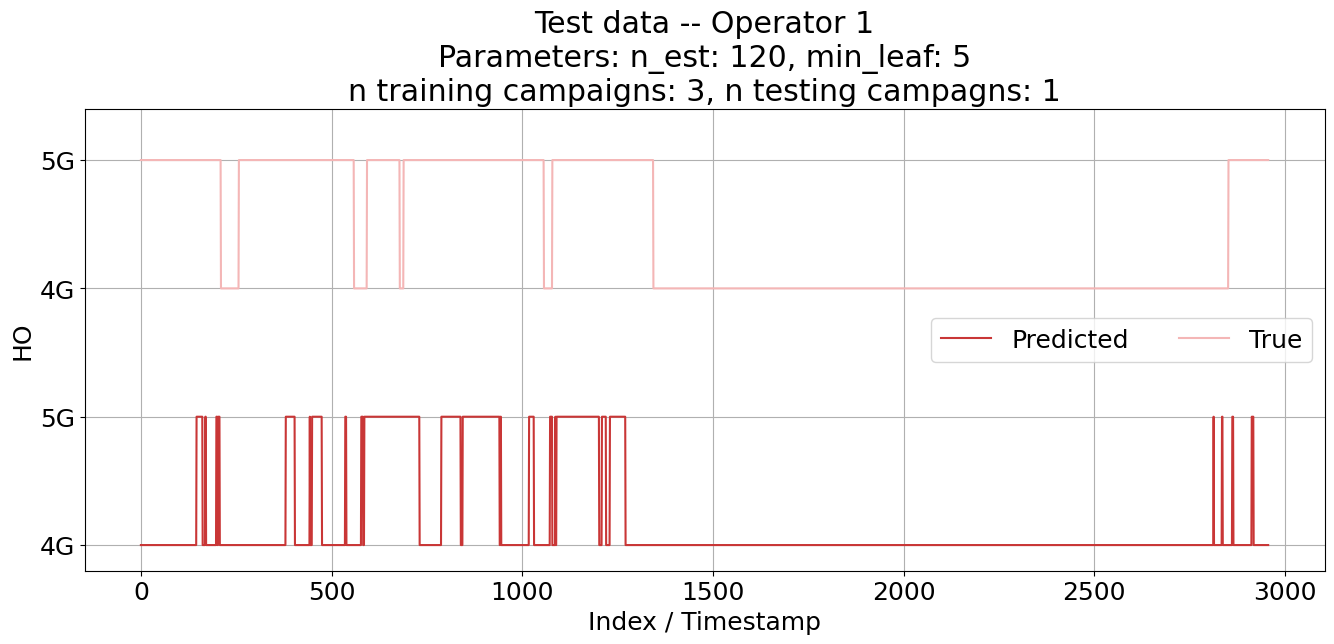

In [77]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true'].values

fig = plot_mode(pred=rf_pred, true=rf_true, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/rf_loc/op1_3_campaign_train_lat_long.pdf')

### Train 4 campaigns -- Test 1 campaign

In [ ]:
new_route = read_dataset(dataset, campaigns=[overlap_1[4]])
test = read_dataset(dataset, campaigns=[overlap_1[0]])

new_route = new_route[5400::]

train = pd.concat([new_route, train])
train.reset_index(drop=True, inplace=True)

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [79]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.629,0.717,0.294,0.998,0.995,0.996
1,"n_est: 5, min_leaf: 2",0.607,0.662,0.267,0.997,0.993,0.993
2,"n_est: 5, min_leaf: 5",0.627,0.705,0.302,0.991,0.968,0.993
3,"n_est: 5, min_leaf: 7",0.652,0.758,0.339,0.992,0.977,0.987
4,"n_est: 5, min_leaf: 9",0.598,0.620,0.284,0.990,0.962,0.993
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.644,0.744,0.322,0.996,0.987,0.994
73,"n_est: 300, min_leaf: 7",0.646,0.750,0.324,0.994,0.979,0.992
74,"n_est: 300, min_leaf: 9",0.635,0.726,0.308,0.992,0.973,0.990
75,"n_est: 300, min_leaf: 12",0.638,0.724,0.323,0.990,0.967,0.988


In [80]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.633
Mean precision: 0.720
Mean recall: 0.309


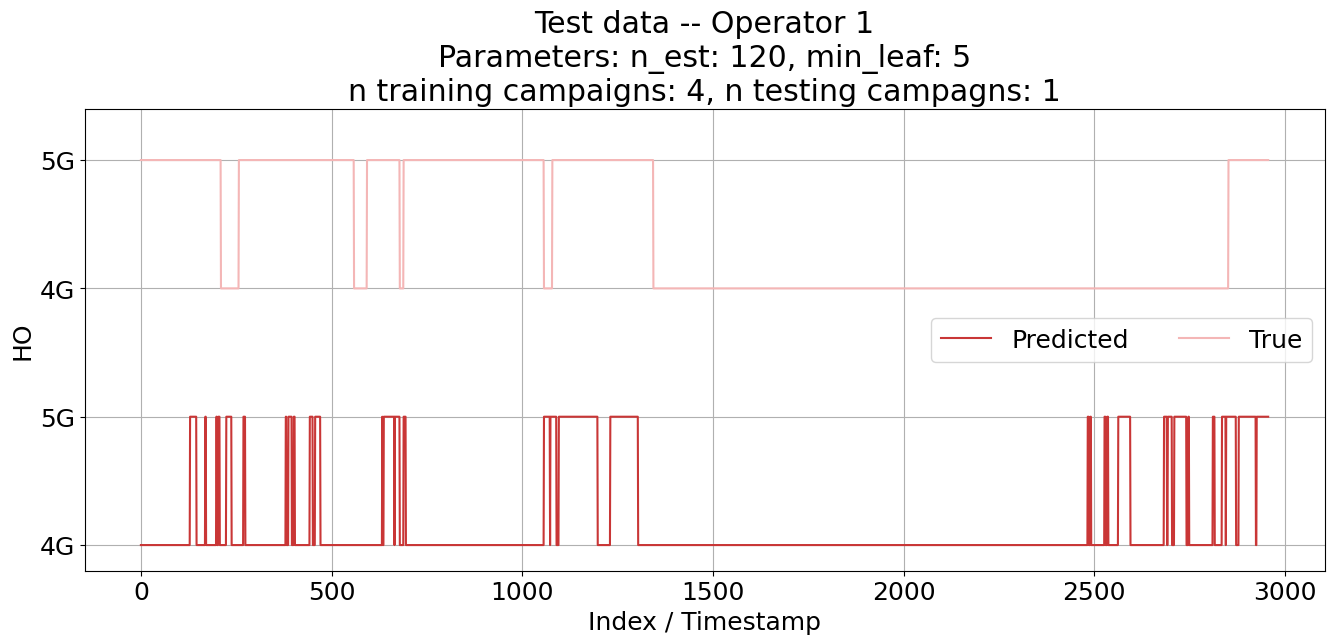

In [81]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true'].values

fig = plot_mode(pred=rf_pred, true=rf_true, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/rf/op1_4_campaign_train.pdf')

#### Include location

In [82]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.666,0.870,0.305,0.998,0.996,0.996
1,"n_est: 5, min_leaf: 2",0.684,0.879,0.350,0.999,0.997,0.996
2,"n_est: 5, min_leaf: 5",0.834,0.924,0.690,0.995,0.982,0.996
3,"n_est: 5, min_leaf: 7",0.712,0.884,0.416,0.994,0.977,0.998
4,"n_est: 5, min_leaf: 9",0.695,0.911,0.361,0.990,0.964,0.993
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.708,0.954,0.373,0.997,0.988,0.998
73,"n_est: 300, min_leaf: 7",0.714,0.945,0.389,0.996,0.984,0.998
74,"n_est: 300, min_leaf: 9",0.725,0.944,0.416,0.995,0.982,0.997
75,"n_est: 300, min_leaf: 12",0.725,0.945,0.415,0.994,0.973,0.998


In [83]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.711
Mean precision: 0.938
Mean recall: 0.386


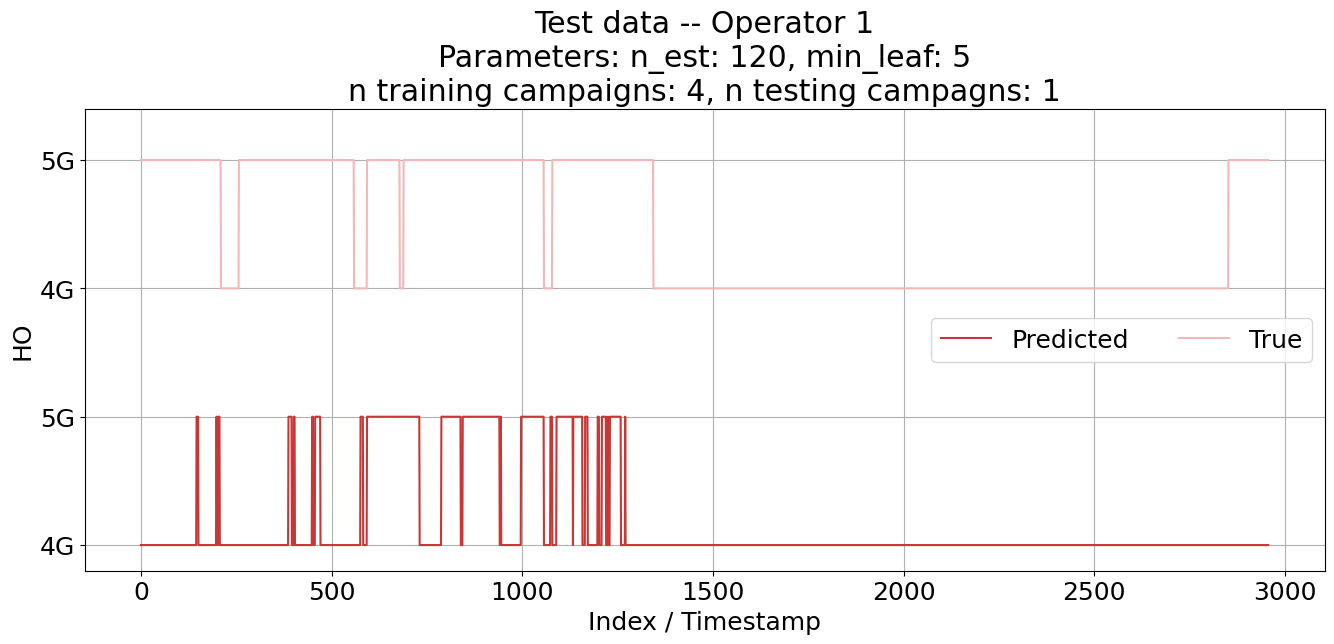

In [84]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true'].values

fig = plot_mode(pred=rf_pred, true=rf_true, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/rf_loc/op1_3_campaign_train_lat_long.pdf')

### Train 5 campaigns -- Test 1 campaign

In [ ]:
new_route = read_dataset(dataset, campaigns=[overlap_1[5]])
test = read_dataset(dataset, campaigns=[overlap_1[0]])

new_route = new_route[0:1180]

train = pd.concat([new_route, train])
train.reset_index(drop=True, inplace=True)

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [86]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.627,0.686,0.323,0.998,0.993,0.996
1,"n_est: 5, min_leaf: 2",0.634,0.692,0.344,0.996,0.989,0.993
2,"n_est: 5, min_leaf: 5",0.622,0.679,0.310,0.993,0.976,0.994
3,"n_est: 5, min_leaf: 7",0.651,0.701,0.397,0.990,0.967,0.988
4,"n_est: 5, min_leaf: 9",0.636,0.693,0.350,0.986,0.949,0.991
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.650,0.740,0.346,0.995,0.982,0.995
73,"n_est: 300, min_leaf: 7",0.652,0.743,0.351,0.994,0.980,0.992
74,"n_est: 300, min_leaf: 9",0.650,0.741,0.345,0.991,0.969,0.991
75,"n_est: 300, min_leaf: 12",0.650,0.734,0.353,0.989,0.961,0.990


In [87]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.647
Mean precision: 0.726
Mean recall: 0.351


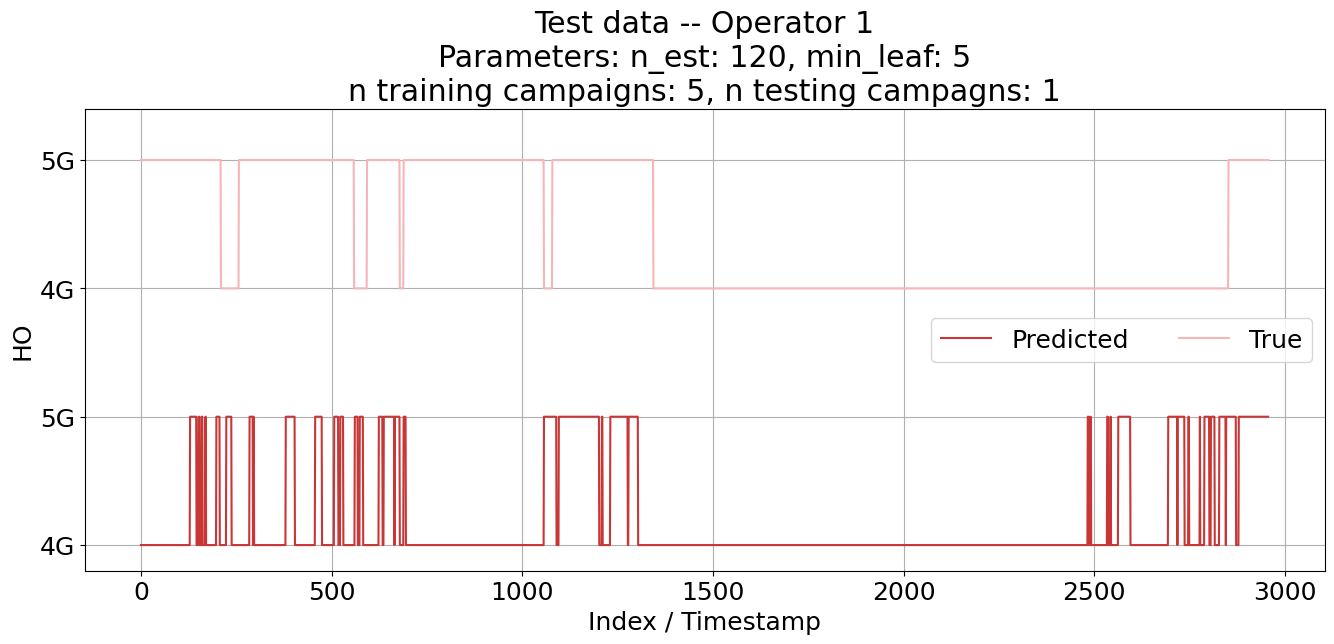

In [88]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true'].values

fig = plot_mode(pred=rf_pred, true=rf_true, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/rf/op1_5_campaign_train.pdf')

#### Include location

In [89]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

,Parameters,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,"n_est: 5, min_leaf: 1",0.717,0.872,0.438,0.999,0.998,0.998
1,"n_est: 5, min_leaf: 2",0.671,0.890,0.309,0.998,0.996,0.997
2,"n_est: 5, min_leaf: 5",0.615,0.825,0.187,0.996,0.988,0.997
3,"n_est: 5, min_leaf: 7",0.672,0.894,0.310,0.995,0.982,0.995
4,"n_est: 5, min_leaf: 9",0.648,0.872,0.259,0.993,0.972,0.999
...,...,...,...,...,...,...,...
72,"n_est: 300, min_leaf: 5",0.722,0.936,0.414,0.997,0.990,0.997
73,"n_est: 300, min_leaf: 7",0.729,0.944,0.426,0.996,0.986,0.998
74,"n_est: 300, min_leaf: 9",0.716,0.951,0.391,0.996,0.984,0.998
75,"n_est: 300, min_leaf: 12",0.723,0.939,0.415,0.994,0.978,0.996


In [90]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.707
Mean precision: 0.929
Mean recall: 0.381


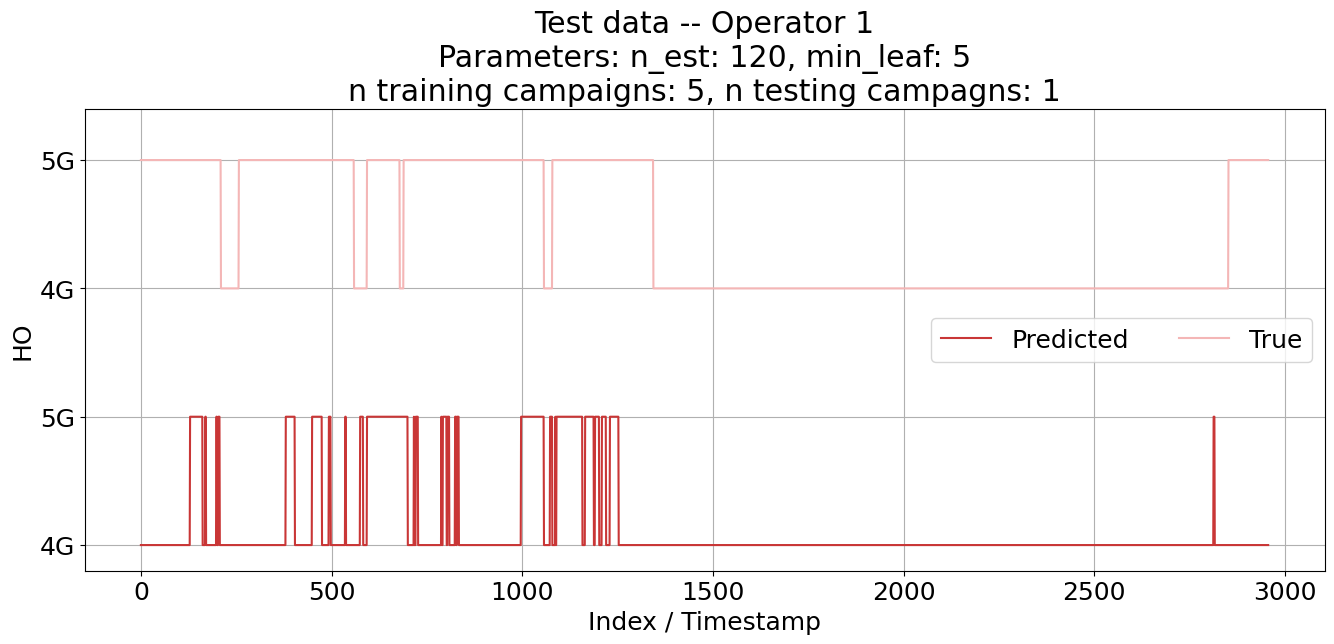

In [91]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true'].values

fig = plot_mode(pred=rf_pred, true=rf_true, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/rf_loc/op1_5_campaign_train_lat_long.pdf')